In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scienceplots

import ams

In [2]:
%matplotlib inline

In [3]:
case_path = "./../cases"
res_path = "./../results"

In [4]:
sp = ams.load(case_path + '/IL200_opf2.xlsx',
              setup=True, no_output=True,
              default_config=True)

# NOTE: 1) the maximum number of dispatch should follow: "D * Dispatch_interval <= 3600"
#       2) the maximum number of AGC should follow: "Dispatch_interval % AGC_interval == 0"

Dispatch_interval = 900  # seconds
AGC_interval = 15  # seconds

pq_idx = sp.PQ.idx.v
p0 = sp.PQ.p0.v.copy()
q0 = sp.PQ.q0.v.copy()

stg = sp.StaticGen.get_all_idxes()

stg_idxes = sp.StaticGen.find_idx(keys='gentype',
                                  values=['W2', 'PV', 'ES'],
                                  allow_all=True)

stg_w2t, stg_pv, stg_ess = stg_idxes

p0_w2t = sp.StaticGen.get(src='p0', attr='v', idx=stg_w2t)
p0_pv = sp.StaticGen.get(src='p0', attr='v', idx=stg_pv)

In [5]:
opf_res = pd.read_json(f"{res_path}/opf.json")

In [6]:
wind = [sp.config.mva * p0_w2t.sum() * opf_res[col]['wind'] for col in opf_res.columns]
solar = [sp.config.mva * p0_pv.sum() * opf_res[col]['solar'] for col in opf_res.columns]
gen = [sp.config.mva * np.sum(opf_res[col]['pg']) for col in opf_res.columns]
load = [sp.config.mva *np.sum(opf_res[col]['pd']) for col in opf_res.columns]

In [7]:
plt.style.use(["default", "ieee"])

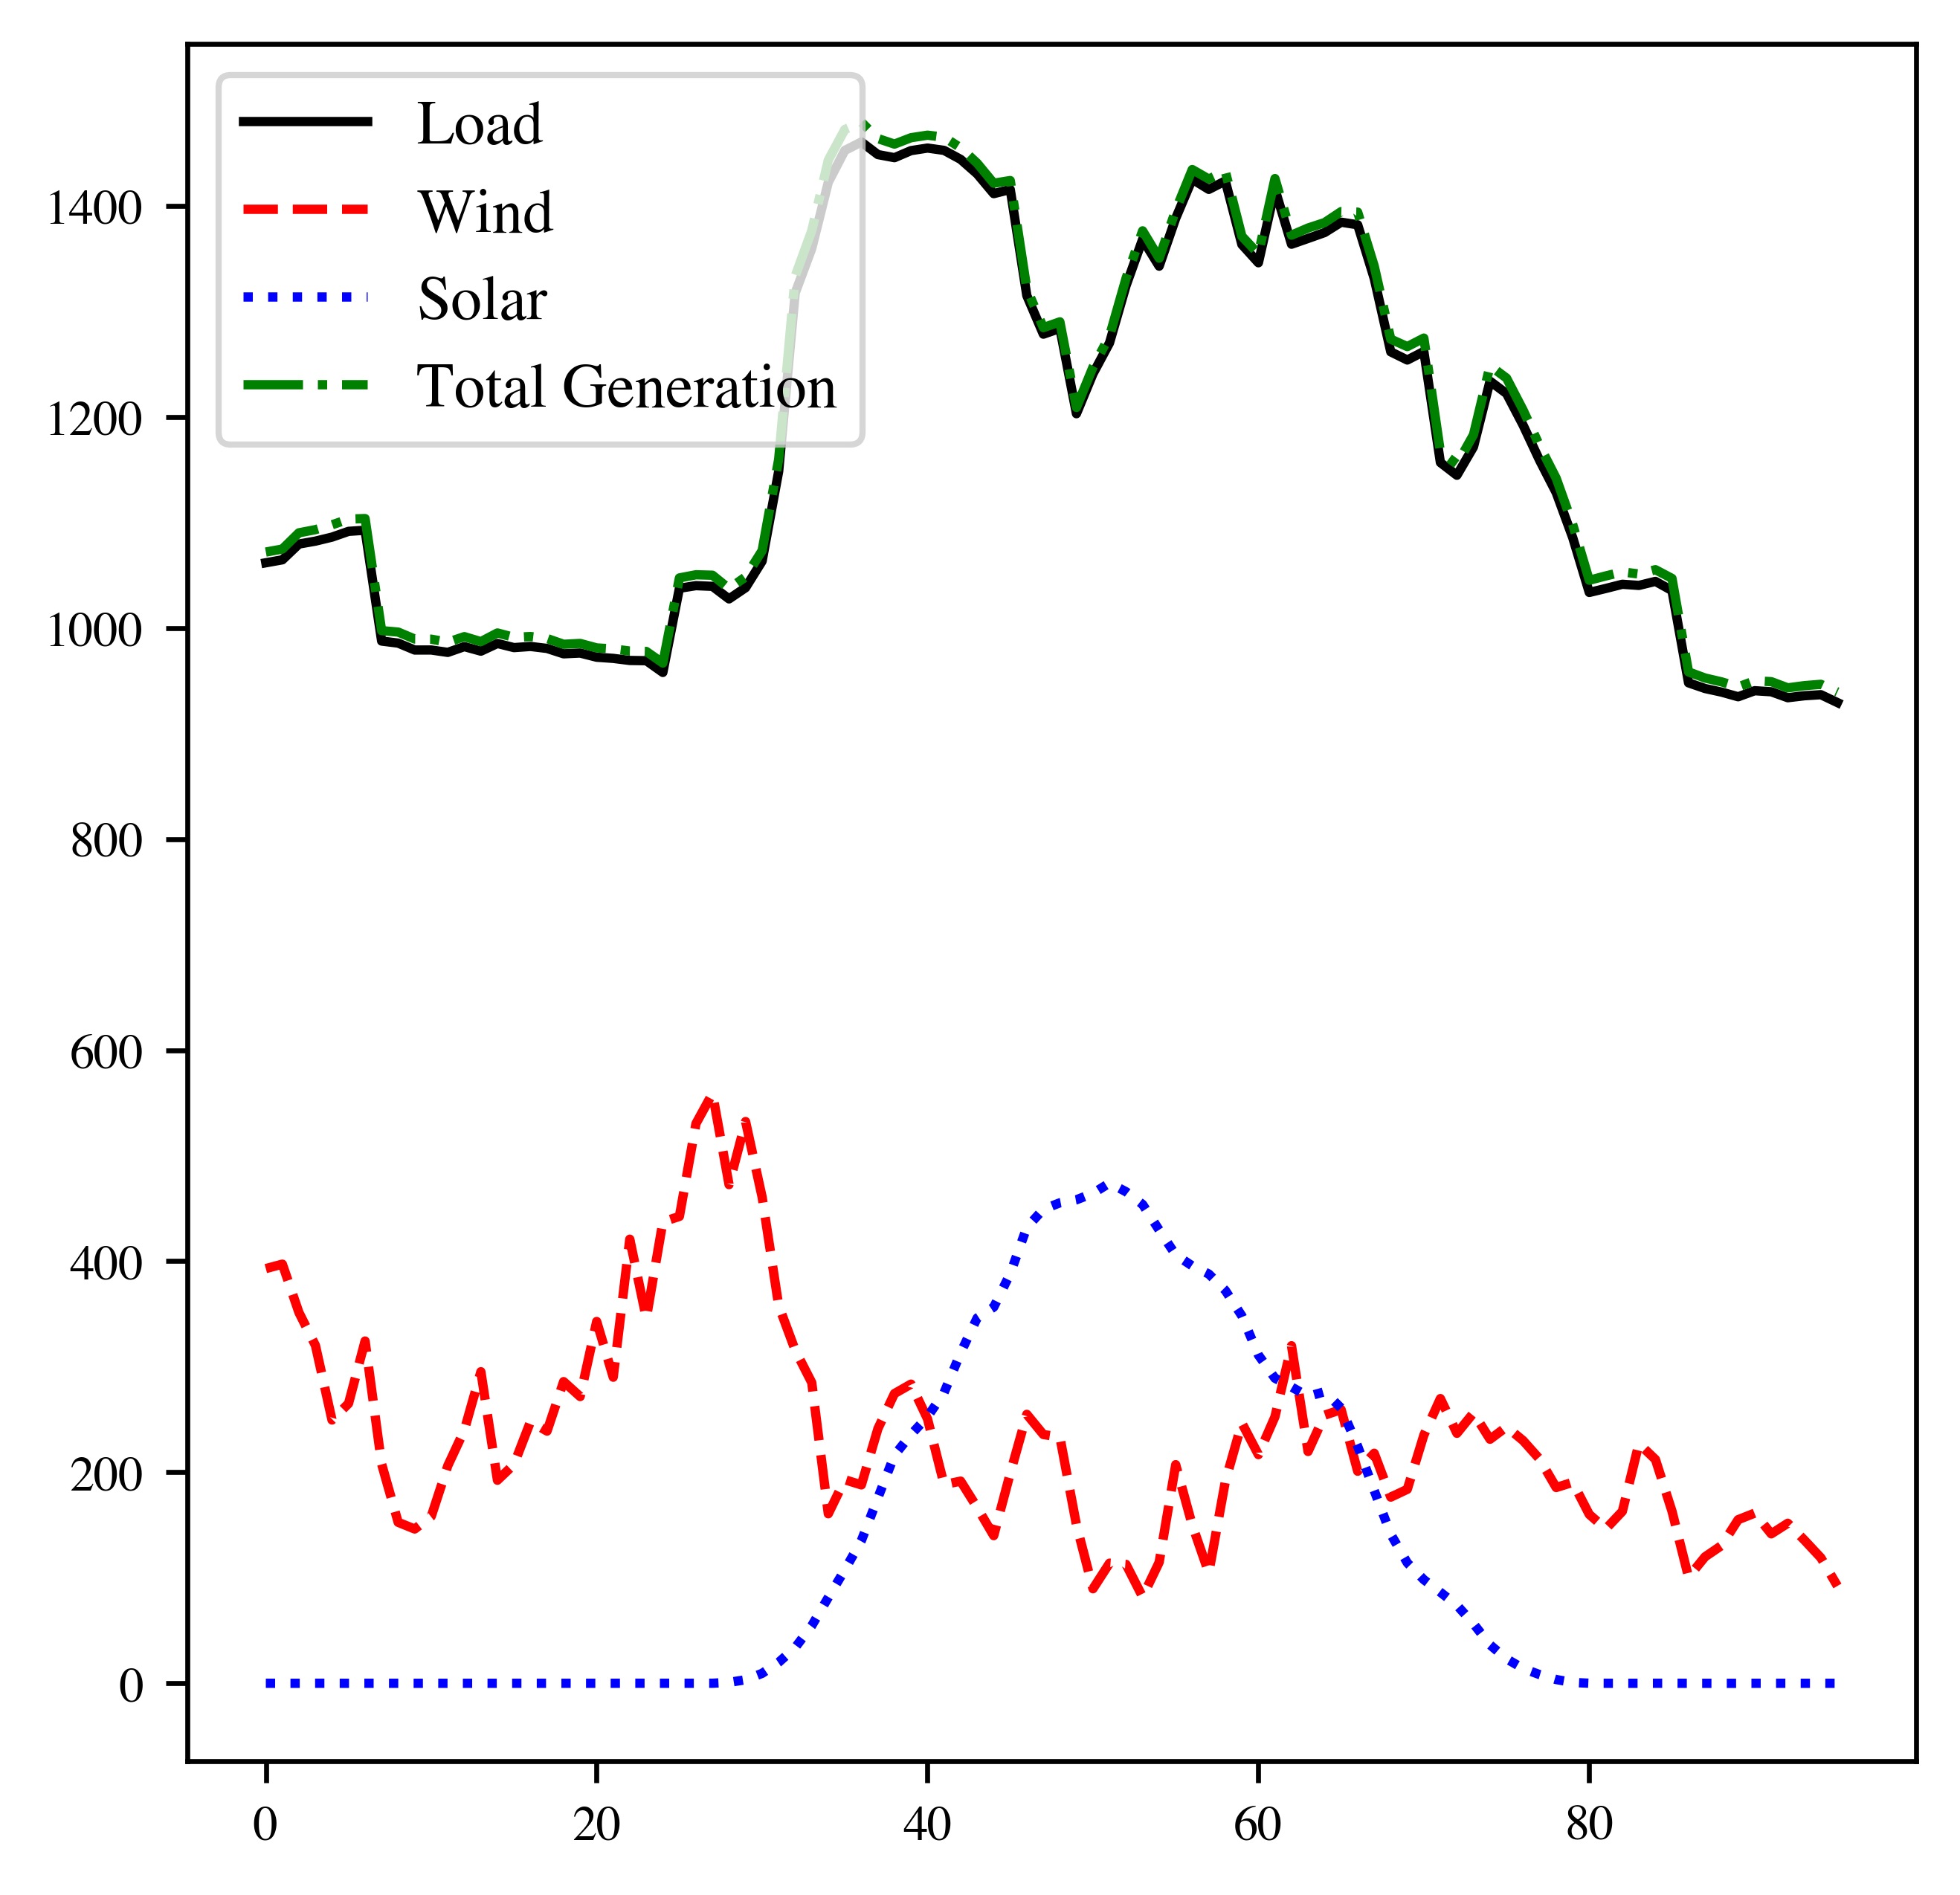

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = ax.plot(range(opf_res.shape[1]), load, label='Load')
_ = ax.plot(range(opf_res.shape[1]), wind, label='Wind')
_ = ax.plot(range(opf_res.shape[1]), solar, label='Solar')
_ = ax.plot(range(opf_res.shape[1]), gen, label='Total Generation')
_ = ax.legend(loc='upper left', fontsize=10)

In [9]:
res = pd.read_csv(f"{res_path}/tds_h22_d1.csv")
res = res.iloc[1:]

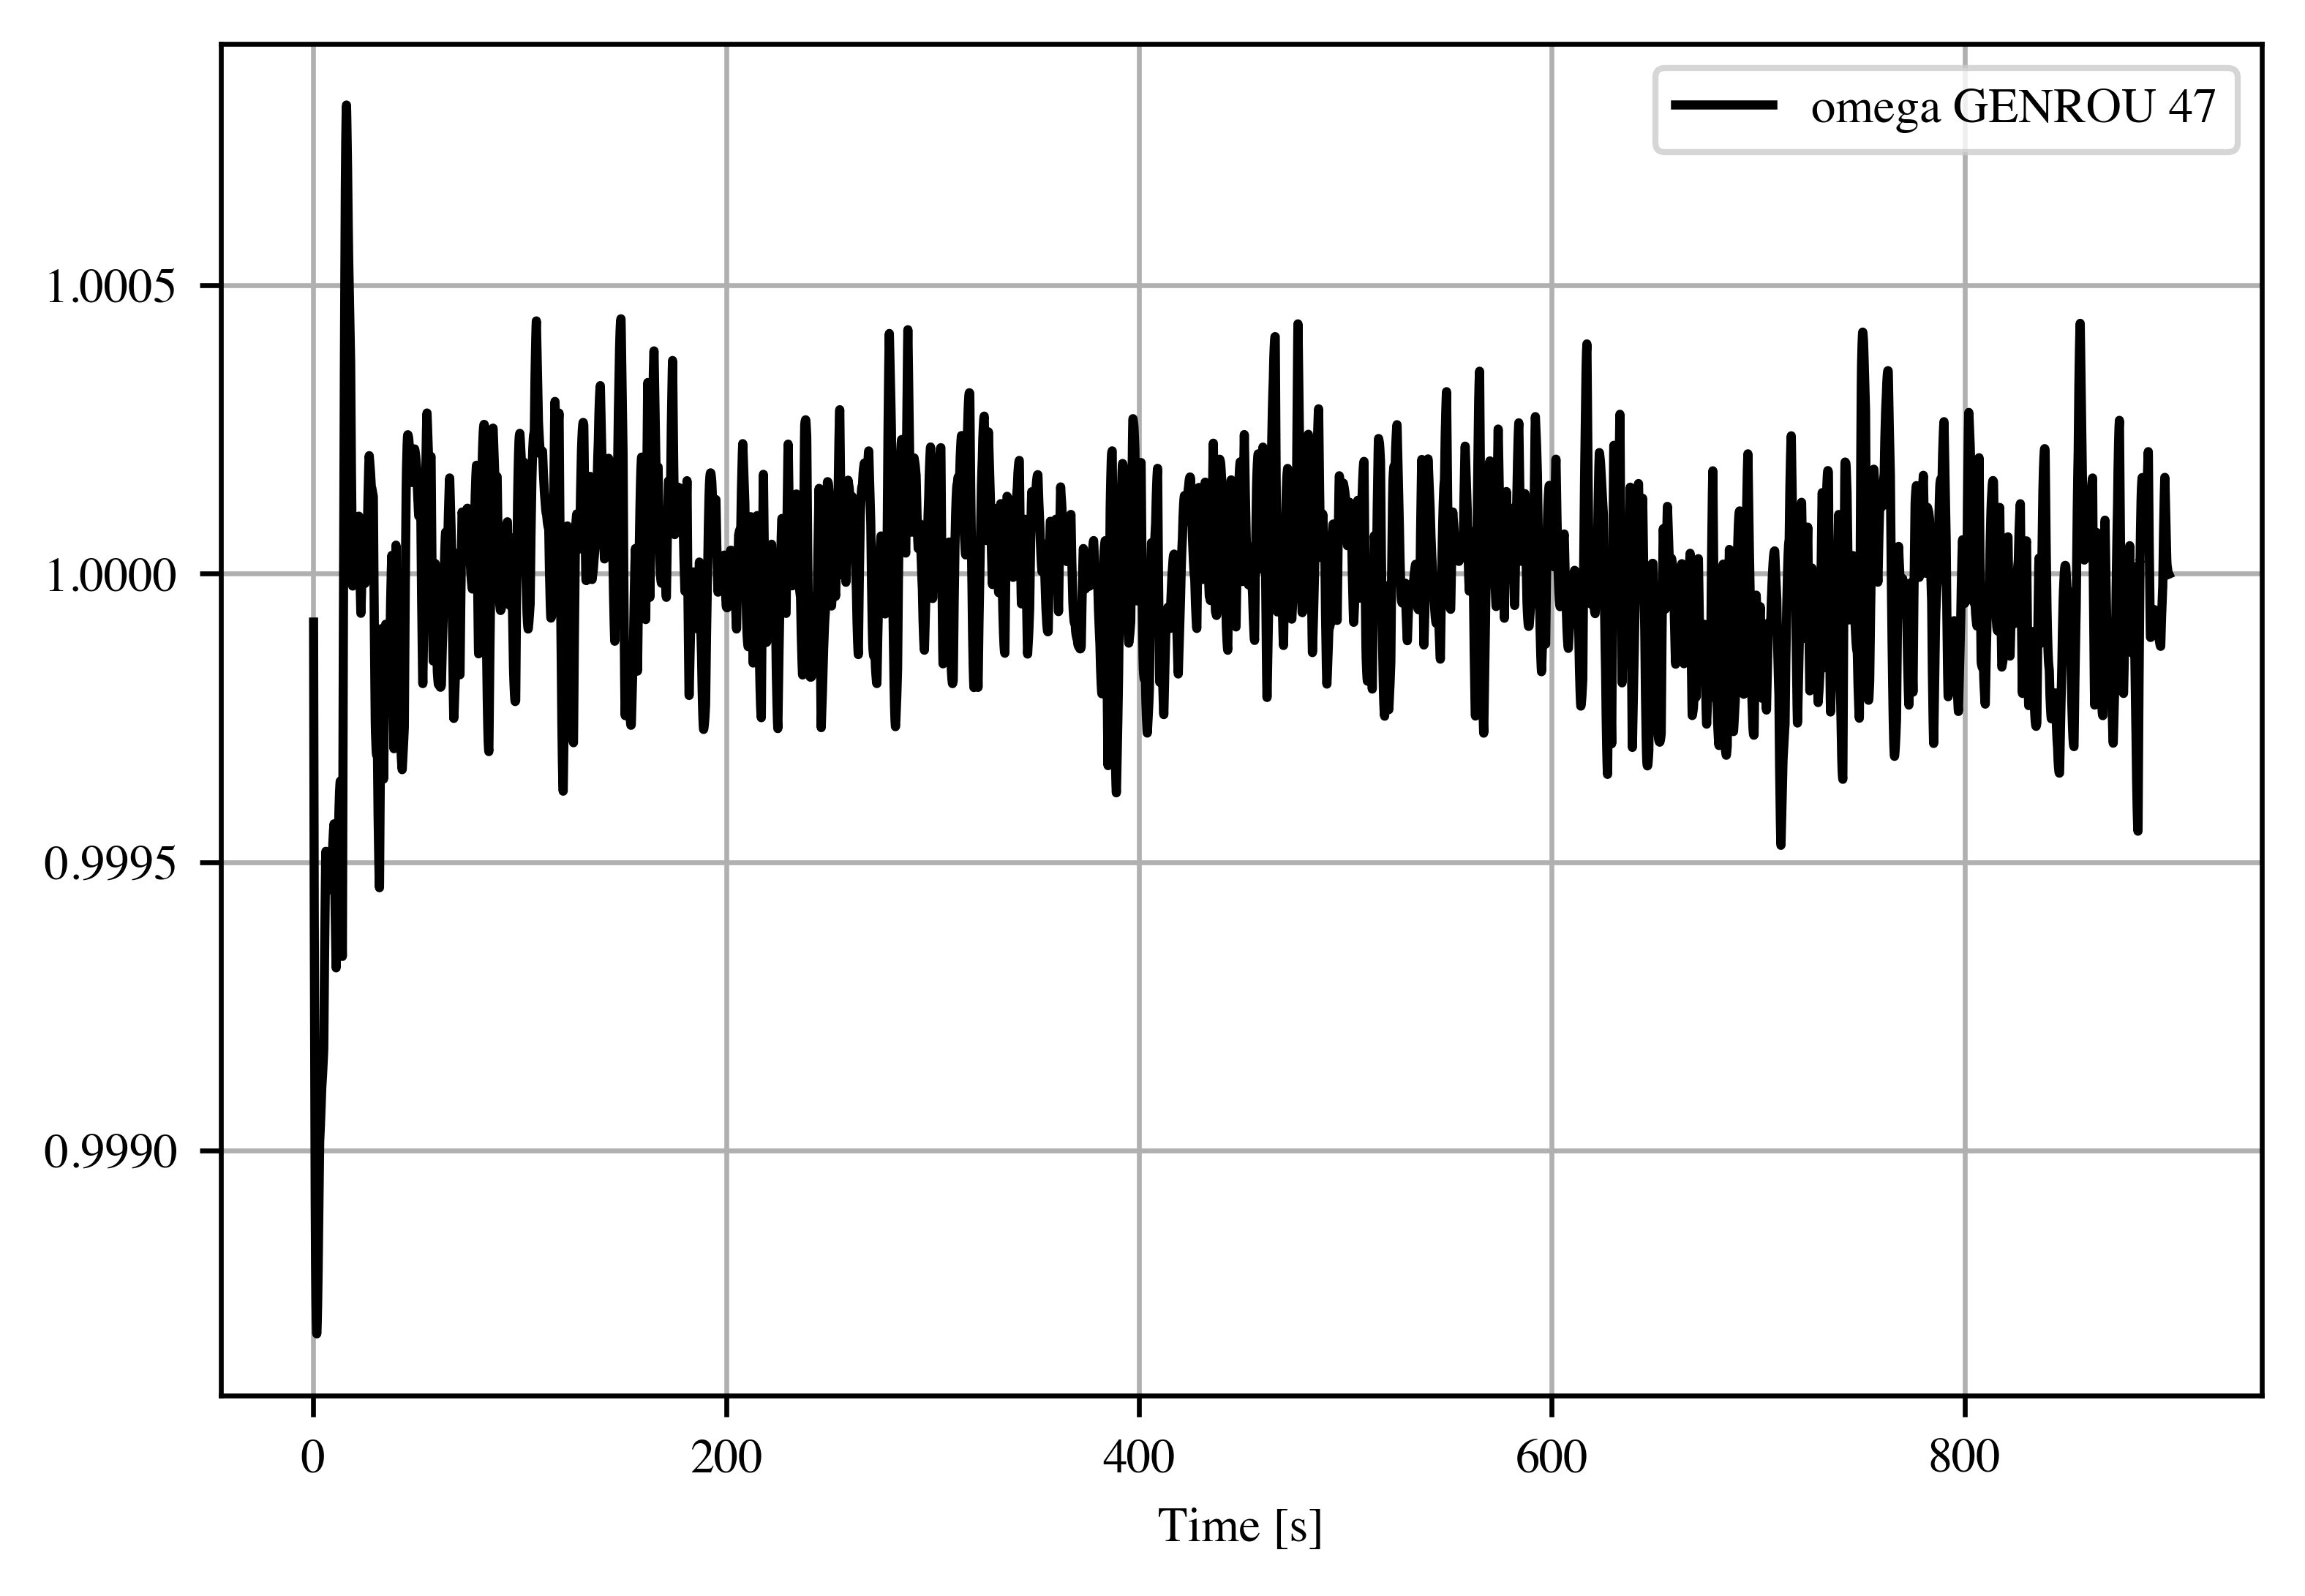

In [10]:
plt.style.use(["default", "ieee"])
ax = res.plot(x="Time [s]",
              y=["omega GENROU 47"],
              figsize=(6, 4),
              grid=True,)